# Поиск клиента с неоптимальными тарифами
----

## Описание проекта
* Датасеты содержат данные об использовании услуг виртуальной телефонии "Нупозвони". Клиентами "Нупозвони" являются организации, которым нужно распределять множество входящих вызовов на различных операторов, либо осуществлять исходящие вызовы силами операторов. __Также операторы могут осуществлять внутренние вызовы, то есть вызовы друг между другом, которые осуществляются внутри сети виртуальной телефонии.__


## Задача
* Найти клиентов, которые: 
    * а) переплачивают на текущих тарифах;
    * б) требуют повышения тарифного плана, т.к. им это будет выгоднее.
* В проекте отдельно укажите 5-10 источников (документация, статьи), которые вы использовали во время работы. Кратко опишите ответы на какие вопросы вы нашли в них.

---
## Описание данных
* Датасет __telecom_dataset.csv__:
    * __user_id__ - Идентификатор клиентского аккаунта в сервисе
    * __date__ - Дата статистики
    * __direction__ - Направление вызовов (out - исходящий вызов, in - входящий вызов)
    * __internal__ - Является ли звонок внутренним звонком между операторами клиента
    * __operator_id__ - Идентификатор оператора
    * __is_missed_call__ - Является ли звонок пропущенным
    * __calls_count__ - Количество звонков
    * __call_duration__ - Длительность звонка (без учета времени ожидания)
    * __total_call_duration__ - Длительность звонка (с учетом времени ожидания)

* Датасет __telecom_clients.csv__:
    * __user_id__ - Идентификатор клиентского аккаунта в сервисе
    * __tariff_plan__ - Текущий тарифный план клиента
    * __date_start__ - Дата регистрации клиентв в сервисе



---
## Правила формирования тарифов
    * Базовая стоимость тарифного плана A - 5000 условных единиц
    * Базовая стоимость тарифного плана B - 2000 условных единиц
    * Базовая стоимость тарифного плана C - 1000 условных единиц
    * Входящие звонки на всех тарифах - бесплатные
### Внутренние звонки на всех тарифах - бесплатные до 2000 минут разговоров в месяц, после чего тарифицируются:
    * Тарифный план A - 0.1 условных единиц за минуту
    * Тарифный план B - 0.15 условных единиц за минуту
    * Тарифный план C - 0.3 условных единиц за минуту
### Исходящие (не внутренние) звонки:
    * Тарифный план A - 0.4 условных единиц за минуту
    * Тарифный план B - 0.5 условных единиц за минуту
    * Тарифный план C - 0.7 условных единиц за минуту
За каждого оператора клиент платит 100 условных единиц на любом тарифе дополнительно к базовой стоимости тарифного плана и тарификации за звонки


---

### [-->](#step_1) Шаг 1. Предобработка и предварительное исследование данных 
### [-->](#step_2) Шаг 2. Сбор агрегированных данных в датафрейм для анализа
### [-->](#step_3) Шаг 3. Исследовательский анализ данных
### [-->](#step_4) Шаг 4. Визуализация и бизнес метрики
### [-->](#step_5) Шаг 5. Кластеризация
### [-->](#step_6) Шаг 6. Формирование выводов
### [-->](#step_7) Шаг 7. Презентация

---

## Источники
1. Как работают виртуальные АТС
    1. https://sipuni.com/ru_RU/virtual-pbx/how-it-works
    2. https://blog.calltouch.ru/kak-rabotaet-virtualnaya-ats/
2. Как разбить на несколько столбцов оптимальным способом, split, expand=True
    1. https://codengineering.ru/q/how-to-split-a-column-into-two-columns-16600/
3. Интересный график распределения sns.stripplot (boxplot+точечная диаграмма)
    1. https://temofeev.ru/info/articles/50-ottenkov-matplotlib-the-master-plots-s-polnym-kodom-na-python/
4. Вспоминал как считаютс arpu и arppu
    1. https://www.carrotquest.io/blog/arpu/
5. Как поменять местами ключи и значения в словаре
    1. https://stackoverflow.com/questions/483666/reverse-invert-a-dictionary-mapping

6. Почти в каждой работе смотрю параметры у разных графиков, когда забываю что есть что
    1. https://python-graph-gallery.com/
7. Лучший источник - личный evernote с конспектами и всякими фишками
    1. http://joxi.ru/Dr85dd5uz4MD0m


----

In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format

# Шаг 1. Предобработка и предварительное исследование данных 
<a class="anchor" id="step_1"></a>

In [265]:
#объявим пути
path_telecom_dataset = '/Users/peter/Desktop/praktikum_last_projects/last_project/telecom_dataset.csv'
path_telecom_clients = '/Users/peter/Desktop/praktikum_last_projects/last_project/telecom_clients.csv'

In [266]:
#загрузим данные
df_general = pd.read_csv(path_telecom_dataset)
df_clients = pd.read_csv(path_telecom_clients)

In [5]:
def firstlook(df):
    '''
    Функция для обзора датасета, размер, пропущенные значения, описание, типы даных, основные статистики
    '''
    print()
    print('=================')
    print(f'Размер датафрейма \n{df.shape}')
    print()
    print('=================')
    print(f'Info \n{df.info()}')
    print()
    print('=================')
    print(f'Доля пропущенных значений \n{df.isna().sum()/df.shape[0]}')
    print()
    print('=================')
    print(f'Количество дубликатов \n{df.duplicated().sum()} - доля: {df.duplicated().sum()/df.shape[0]}')
    print()
    print('=================')
    print(f'Описание данных')
    display(df.describe())
    print('=================')
    display(df.head())

In [6]:
df_clients.user_id.nunique()

732

In [7]:
df_general.user_id.nunique()

307

### Обзор датафрейма df_general

In [8]:
firstlook(df_general)


Размер датафрейма 
(3848183, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848183 entries, 0 to 3848182
Data columns (total 9 columns):
user_id                int64
date                   object
direction              object
internal               object
operator_id            float64
is_missed_call         bool
calls_count            int64
call_duration          int64
total_call_duration    int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 238.5+ MB
Info 
None

Доля пропущенных значений 
user_id               0.00
date                  0.00
direction             0.00
internal              0.00
operator_id           0.15
is_missed_call        0.00
calls_count           0.00
call_duration         0.00
total_call_duration   0.00
dtype: float64

Количество дубликатов 
3799181 - доля: 0.9872661980992068

Описание данных


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,"3,848,183.00","3,251,758.00","3,848,183.00","3,848,183.00","3,848,183.00"
mean,"167,102.67","910,830.57",15.00,850.41,"1,122.44"
std,546.21,"20,309.55",61.49,"4,254.02","5,017.63"
min,"166,377.00","879,896.00",1.00,0.00,0.00
25%,"166,658.00","893,674.00",1.00,0.00,45.00
50%,"166,997.00","906,394.00",4.00,38.00,189.00
75%,"167,479.00","924,934.00",11.00,550.00,802.00
max,"168,606.00","973,286.00","4,817.00","144,395.00","166,155.00"


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,167130,2019-09-10 00:00:00+03:00,out,False,"902,608.00",False,42,2830,3744
1,167130,2019-09-07 00:00:00+03:00,in,True,nan,True,3,0,6
2,167130,2019-09-11 00:00:00+03:00,out,False,"902,608.00",False,38,1578,2274
3,167130,2019-09-12 00:00:00+03:00,out,True,"902,608.00",True,2,0,9
4,167130,2019-09-04 00:00:00+03:00,in,False,"902,608.00",False,1,106,110


### Обзор датафрейма df_clients

In [9]:
firstlook(df_clients)


Размер датафрейма 
(732, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
Info 
None

Доля пропущенных значений 
user_id       0.00
tariff_plan   0.00
date_start    0.00
dtype: float64

Количество дубликатов 
0 - доля: 0.0

Описание данных


,user_id
count,732.00
mean,"167,431.93"
std,633.81
min,"166,373.00"
25%,"166,900.75"
50%,"167,432.00"
75%,"167,973.00"
max,"168,606.00"


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


## Датафрейм df_general

#### В датафрейме найдено большое количество дублей, 98,7%
* Причина возникновения скорее всего в неправильном мерже по абонентам компании, например по номерам, которых нет в выгрузке
* Предполагаю, что данные пишутся для не_внутренних звонков в день двумя строками отдельно для IN и OUT вызовов
* Наши клиенты это бизнес с большим количеством входящих звонков, каждый отрезок времени поступают звонки, при это детализация в выгрузке дана по дням. Все количество звонков агрегируется за день и записывается как одна строка с пометкой in.
* Далее это же количество звонков(или чуть меньше, если кто-то не дождался переадресации) перераспределяется на номера сотрудников и весь бакет с этими звонками за день записывается с пометкой out.
* Для каждого клиентского аккаунта есть максимальное число одновременно входящих звонков, и максимальное количество уникальных исходящих звонков (операторов) за которые клиенты платят отдельно. Будем это называть слотом или разрешающей способностью по каждому клиенту, возможно дальше это понадобиться.

#### Определим типы данных
* __date__ - переведем в datetime, уберем время (константа, не несет информации, данные пишутся за весь день исходя из типа звонка и направления)
* __internal__ - переведем в bool
* __direction__ - переведем в category

## Датафрейм df_clients

#### Определим типы данных
* __tariff_plan__ - переведем в category
* __date_start__ - переведем в datetime

### Поменяем типы данных в df_general

In [267]:
#разделим дату на два столбца, отделим время
df_general[['date', 'time']] = df_general['date'].str.split(' ', expand = True)
#удалим константное время
df_general.drop(['time'], axis=1, inplace=True)
#переведем дату в datetime
df_general['date'] = pd.to_datetime(df_general['date'])

In [268]:
df_general['internal'] = df_general['internal'].astype('bool')
df_general['direction'] = df_general['direction'].astype('category')

In [269]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848183 entries, 0 to 3848182
Data columns (total 9 columns):
user_id                int64
date                   datetime64[ns]
direction              category
internal               bool
operator_id            float64
is_missed_call         bool
calls_count            int64
call_duration          int64
total_call_duration    int64
dtypes: bool(2), category(1), datetime64[ns](1), float64(1), int64(4)
memory usage: 187.2 MB


### Удалим дубликаты в df_general

In [270]:
_ = df_general.shape[0]
df_general.drop_duplicates(keep='first', inplace=True)
print(f'Из датафрейма df_general удалили {_-df_general.shape[0]} дубликатов\nили {1-df_general.shape[0]/_:.1%}')

Из датафрейма df_general удалили 3799181 дубликатов
или 98.7%


In [271]:
df_general.shape

(49002, 9)

In [272]:
df_general.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,167130,2019-09-10,out,False,"902,608.00",False,42,2830,3744
1,167130,2019-09-07,in,True,nan,True,3,0,6
2,167130,2019-09-11,out,False,"902,608.00",False,38,1578,2274


### Поменяем типы данных в df_clients

In [273]:
df_clients['tariff_plan'] = df_clients['tariff_plan'].astype('category')
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'], format='%Y-%m-%d')

In [274]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null category
date_start     732 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.4 KB


In [275]:
df_clients.head(3)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29


In [276]:
print(f'В датафрейме df_general {df_general.user_id.nunique()} уникальных пользователей\n'
      f'В датафрейме df_clients {df_clients.user_id.nunique()} уникальных пользователей')

В датафрейме df_general 307 уникальных пользователей
В датафрейме df_clients 732 уникальных пользователей


### Вывод: 
* Услуги облачной АТС оплачивают 732 пользователя, однако из них активно используют только 307. Тк в данных у нас нет показателя оттока/даты закрытия контракта, то таких клиентов будем считать "спящими", которые не пользуются услугами, но оплачивают контракт в соответствии с тарифом.

### Посмотрим на соотношение клиентов по тарифам (датафрейм df_clients)

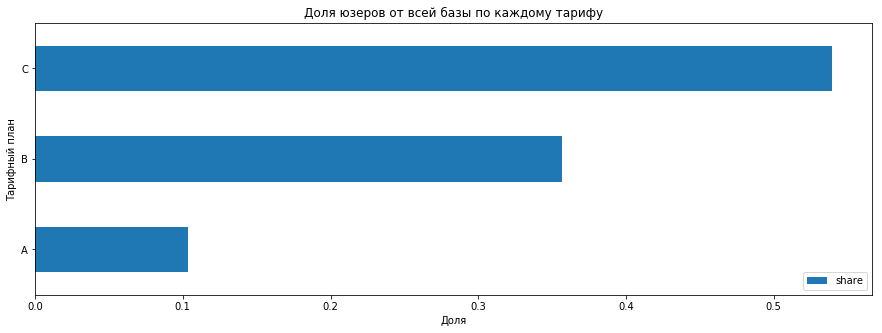

In [277]:
temp = df_clients.groupby('tariff_plan').agg({'user_id':'nunique'}).rename(columns={'user_id':'cnt_users'})
temp['share'] = temp['cnt_users']/df_clients.user_id.nunique()
ax = temp[['share']].plot(kind='barh', figsize=(15,5))
ax.set(title='Доля юзеров от всей базы по каждому тарифу', xlabel='Доля', ylabel='Тарифный план')
plt.show()

In [278]:
temp

,cnt_users,share
tariff_plan,,
A,76,0.10
B,261,0.36
C,395,0.54


## Вывод: 
* Текущий тарифный план A имеют 75 клиентов или 10%
* Текущий тарифный план B имеют 261 клиент или 36%
* Текущий тарифный план C имеют 395 клиент или 54%

---

# Шаг 2. Сбор агрегированных данных в датафрейм для анализа
<a class="anchor" id="step_2"></a>

### 1. Количество уникальных операторов для каждого юзера по месяцам

* За каждого оператора клиент платит 100 условных единиц на любом тарифе дополнительно к базовой стоимости тарифного плана и тарификации за звонки
    * Выделим день начала месяца по каждой записи для каждого user_id
    * Подготовим количество уникальных операторов в каждом месяце по каждому юзеру
    * Только для звонов out

In [279]:
#выделим первый день месяца в датафрейме df_general (понадобиться для оформления периодов)
df_general['month'] = df_general['date'].astype('datetime64[M]')

#выделим первый день месяца в старте контракта датафрейме df_clients (понадобиться для оформления периодов, принимаем что
#юзеры за неполный месяц платят как за полный при подключении, тк тимлид оставил это на свое усмотрение)
df_clients['month_start'] = df_clients['date_start'].astype('datetime64[M]')

In [282]:
df_unique_operators = (df_general[df_general['direction']=='out']).groupby(['user_id','month'])\
                                                                  .agg({'operator_id':'nunique'})\
                                                                  .rename(columns={'operator_id':
                                                                                   'operator_nunique'})\
                                                                  .reset_index()

In [283]:
df_unique_operators.shape

(516, 3)

In [284]:
df_unique_operators.head()

,user_id,month,operator_nunique
0,166377,2019-08-01,5
1,166377,2019-09-01,4
2,166377,2019-10-01,5
3,166377,2019-11-01,4
4,166391,2019-08-01,1


In [285]:
print(f'Медианное количество операторов на пользователя {df_unique_operators.operator_nunique.median()}')

Медианное количество операторов на пользователя 2.0


In [286]:
print(f'Всего уникальных операторов в датафрейме {df_general.operator_id.nunique()}')

Всего уникальных операторов в датафрейме 1092


---

### 2. Найдем первый и последний месяц использования сервиса для каждого клиента

#### 2.1 Найдем последний месяц использования

In [287]:
#на всякий случай
df_last_month = df_general.groupby('user_id').agg({'month':'max'})\
                                             .rename(columns={'month':'last_month_use'})\
                                             .reset_index()

#### 2.2 Найдем первый месяц использования

In [288]:
#на всякий случай
df_first_month = df_clients[['user_id','date_start']].copy()
df_first_month['first_month_use'] = df_first_month['date_start'].astype('datetime64[M]')
df_first_month.drop(['date_start'], axis=1, inplace=True)

----

### 3. Посчитаем in/out звонки и их длительность по каждому user_id в каждом месяце
* Пропущенные звонки не учитываем
* Входящие звонки не учитываем, тк они бесплатные
* Отдельно для внутренних звонков и внешних

#### 3.1 Отдельно внутренние звонки

In [289]:
#уберем входящие звонки и пропущенные звонки
temp = df_general[(df_general['direction']!='in') & (df_general['is_missed_call']!=True)]

In [290]:
#отдельно посчитаем метрики для внутренних звонков, internal == True
df_internal = (temp[temp['internal']==True]).groupby(['user_id','month'])\
                                            .agg({'calls_count':'sum','call_duration':'sum',
                                                  'total_call_duration':'sum'})
#поменяем название столбцов
df_internal.columns = ['internal_'+i for i in df_internal]
df_internal.reset_index(inplace=True)

In [291]:
df_internal.head()

,user_id,month,internal_calls_count,internal_call_duration,internal_total_call_duration
0,166377,2019-08-01,1,10,18
1,166377,2019-10-01,1,2,4
2,166377,2019-11-01,1,120,122
3,166405,2019-10-01,9,271,353
4,166405,2019-11-01,4,35,80


#### 3.2 Отдельно внешние звонки

In [292]:
#отдельно посчитаем метрики для наружных звонков, internal == False
df_external = (temp[temp['internal']==False]).groupby(['user_id','month'])\
                                            .agg({'calls_count':'sum','call_duration':'sum',
                                                  'total_call_duration':'sum'})
#поменяем название столбцов
df_external.columns = ['external_'+i for i in df_external]
df_external.reset_index(inplace=True)

In [293]:
df_external.head()

,user_id,month,external_calls_count,external_call_duration,external_total_call_duration
0,166377,2019-08-01,570,64968,69100
1,166377,2019-09-01,873,85609,91886
2,166377,2019-10-01,909,81599,88502
3,166377,2019-11-01,812,78243,84739
4,166405,2019-08-01,282,44039,47869


---

Абонентская плата начисляется за месяц, необходимо посчитать количество месяцев со старта тарифа для каждого клиента, в независимости от того, использует он услуги виртуальной АТС или нет

In [294]:
print(f'В датафрейме df_general {df_general.user_id.nunique()} уникальных пользователей\n'
      f'В датафрейме df_clients {df_clients.user_id.nunique()} уникальных пользователей')

В датафрейме df_general 307 уникальных пользователей
В датафрейме df_clients 732 уникальных пользователей


In [295]:
_ = df_clients.user_id.nunique() - df_general.user_id.nunique()
print(f'В клиентской базе есть {_} уникальных клиентов, которые платят абонентскую плату, но не проявляют активности')

В клиентской базе есть 425 уникальных клиентов, которые платят абонентскую плату, но не проявляют активности


#### Тк у нас нет данных о прекращении использования услуг каким либо пользователем, то всех пользователей считаем активными -> платящими за тариф во всех периодах

---

### 4. Исследуем активность пользователей

#### 4.0 Сколько пользователей на каждом тарифе и сколько у нас тарифов

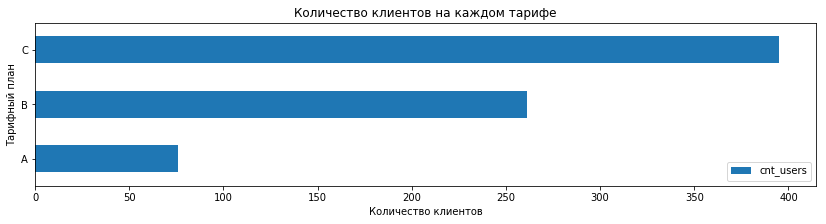

In [296]:
temp = df_clients.groupby('tariff_plan').agg({'user_id':'nunique'}).rename(columns={'user_id':'cnt_users'})
ax = temp.plot(kind='barh', figsize=(14, 3))
ax.set(title = 'Количество клиентов на каждом тарифе', xlabel = 'Количество клиентов', ylabel = 'Тарифный план')
plt.show()

In [297]:
print(f'Количество тарифов: {df_clients.tariff_plan.nunique()}')
temp

Количество тарифов: 3


,cnt_users
tariff_plan,
A,76
B,261
C,395


#### 4.1 Определим дату окончания периода для всех пользователей

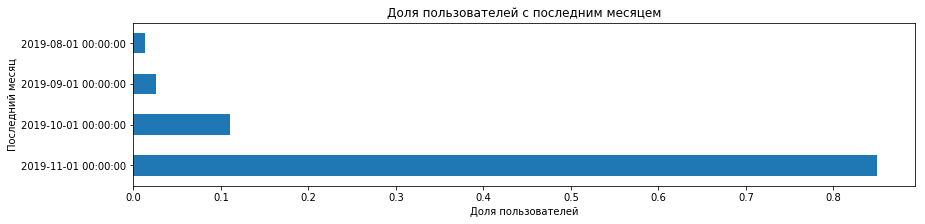

In [298]:
plt.figure(figsize=(14, 3))
ax = (df_last_month.last_month_use.value_counts()/df_last_month.shape[0]).plot(kind='barh',)
ax.set(title = 'Доля пользователей с последним месяцем', ylabel='Последний месяц', xlabel='Доля пользователей')
plt.show()

### Вывод: 
__Т.к. у нас в данных нет даты оттока, то последним месяцем для всех клиентов считаем 2019-11-01, а первым месяцем - дату начала пользования.__
* Тк заказчик не дал информации, платят ли клиенты за полный месяц, если подключились в середине месяца, а тимлид посоветовал определить на свое усмотрение -> принимаю, что подключившиеся в середине месяца, платят за него как за полный месяц. Это похоже на поведение операторов на препейд тарифах.

>**_<span style="color:green">Да, супер, что решил посчитать отток.</span>_**


#### 4.2 Суммарное количество внутренних, исходящих, непропущенных звонков по месяцам по всей базе

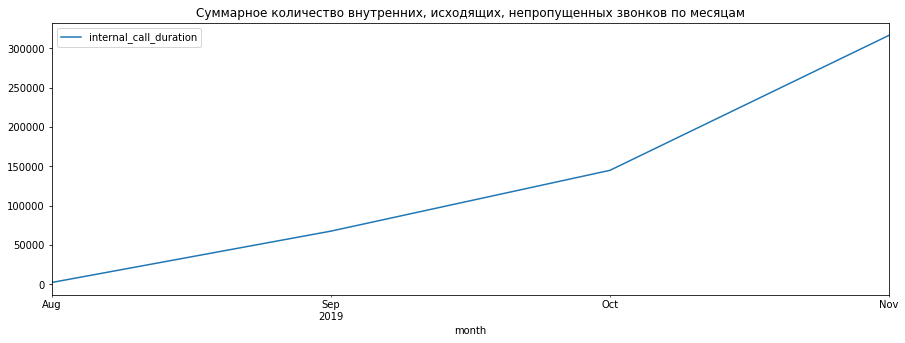

In [299]:
ax = df_internal.groupby('month').agg({'internal_call_duration':'sum'}).plot(figsize=(15,5))
ax.set(title='Суммарное количество внутренних, исходящих, непропущенных звонков по месяцам')
plt.show()

In [300]:
_ = df_internal.groupby('user_id').agg({'internal_calls_count':'sum'})
print(f'Медианное количество внутренних исходящих непропущенных звонков на юзера за весь период: {_.internal_calls_count.median()}')

Медианное количество внутренних исходящих непропущенных звонков на юзера за весь период: 6.0


#### 4.3 Сколько в среднем длится внутренний исходящий звонок

In [301]:
_ = df_internal.groupby('user_id').agg({'internal_call_duration':'mean'})['internal_call_duration'].mean()/60
print(f'В среднем такой звонок длится {round(_,2)} минут')

В среднем такой звонок длится 47.28 минут


#### 4.3 Сколько в среднем длится внешний исходящий звонок

In [302]:
_ = df_external.groupby('user_id').agg({'external_calls_count':'mean'})['external_calls_count'].mean()/60
print(f'В среднем такой звонок длится {round(_,2)} минут')

В среднем такой звонок длится 10.8 минут


#### 4.2 Суммарное количество внешних исходящих звонков по месяцам по всей базе

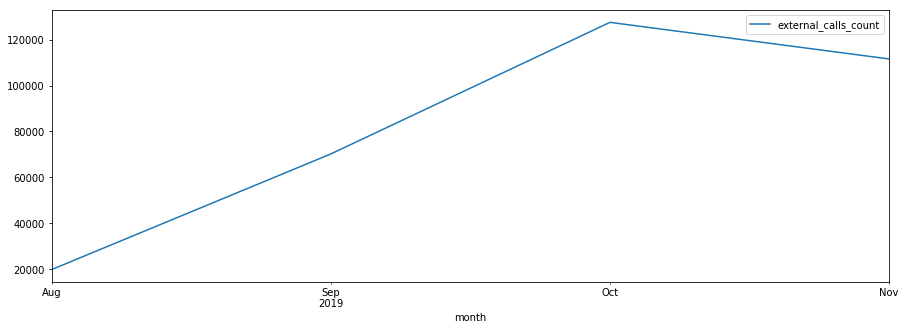

In [303]:
df_external.groupby('month').agg({'external_calls_count':'sum'}).plot(figsize=(15,5))
ax.set(title='Суммарное количество внешних, исходящих звонков по месяцам')
plt.show()

In [304]:
_ = df_external.groupby('user_id').agg({'external_calls_count':'sum'})
print(f'Медианное количество внутренних исходящих непропущенных звонков на юзера за весь период: {_.external_calls_count.median()}')

Медианное количество внутренних исходящих непропущенных звонков на юзера за весь период: 181.0


#### 4.3 Динамика прироста пользователей на каждом из тарифов по месяцам

In [305]:
temp = df_clients.groupby(['month_start','tariff_plan'])['user_id'].count().unstack()

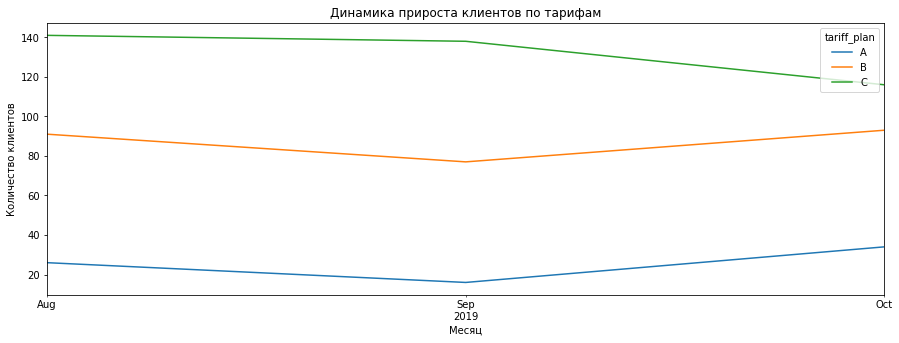

In [306]:
ax = temp.plot(figsize=(15,5))
ax.set(title='Динамика прироста клиентов по тарифам', xlabel='Месяц', ylabel='Количество клиентов')
plt.show()

In [307]:
temp

tariff_plan,A,B,C
month_start,,,
2019-08-01,26,91,141
2019-09-01,16,77,138
2019-10-01,34,93,116


* Странно, что в ноябре нет новых подключений. Но спишем это на особенности выгрузки

#### 4.4 Количество клиентов в каждом тарифе

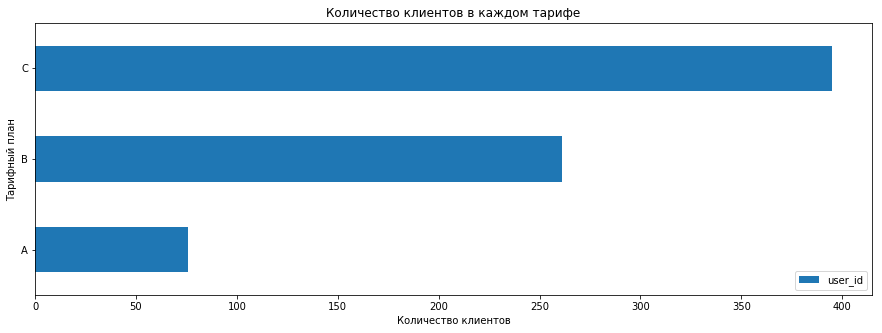

In [308]:
ax = df_clients.groupby('tariff_plan').agg({'user_id':'nunique'}).plot(kind='barh', figsize=(15,5))
ax.set(title='Количество клиентов в каждом тарифе', ylabel= 'Тарифный план', xlabel='Количество клиентов')
plt.show()

----

### 5. Создадим финальный датафрейм со всеми периодами для всех пользователей, в который добавим собранную информацию по активным месяцам
1. Тк пользователи платят каждый месяц за тариф, независимо от того, используют услуги связи или нет - создадим датафрейм в котором для каждого пользователя будет полное количество месяцев использования тарифа
2. Отфильтруем из периодов месяцы "из будущего" до даты заключения контракта __date_start__

#### 5.1 Cоздадим датафрейм в котором для каждого пользователя будет полное количество месяцев использования тарифа

In [309]:
print(f'Определим начало периода, для подготовки финального датафрейма:  '
f'{min([df_general.date.min(),df_clients.date_start.min()])}')

Определим начало периода, для подготовки финального датафрейма:  2019-08-01 00:00:00


In [310]:
print(f'Определим конец периода, для подготовки финального датафрейма:  '
f'{max([df_general.date.max(),df_clients.date_start.max()])}')

Определим конец периода, для подготовки финального датафрейма:  2019-11-28 00:00:00


In [311]:
#создадим датафрейм с периодом от минимального до максимального в наших данных
df = pd.DataFrame(pd.date_range('2019-08-01','2019-11-28', freq='MS'))
#добавим фейковый ключ, по которому будем мержить другие фреймы для каждого юзера
df['key'] = 1
df.columns = ['month','key']

In [312]:
df

,month,key
0,2019-08-01,1
1,2019-09-01,1
2,2019-10-01,1
3,2019-11-01,1


#### 5.2 Добавим в датафрейм с периодами всех юзеров из df_clients и дату старта контракта

In [313]:
#добавим фейковый ключ для мержа
df_clients['key'] = 1
#смержем, на каждого юзера у нас получится 4 месяца
df = df.merge(df_clients, on='key', how='left')
#дропнем фейковый ключ
df.drop(['key'], axis=1, inplace=True)
#удалим периоды "из будущего" до начала контракта
df = df[df['month']>=df['month_start']].copy()

In [314]:
#Проверим что не ошиблись
if df.user_id.nunique() == df_clients.user_id.nunique():
    print('Все OK, все юзеры на месте')
else:
    prtin('Потеряли юзеров')

Все OK, все юзеры на месте


In [315]:
#еще одна проверка по юзеру у которого месяц старта == 2019-10-01, ожидаем 2 месяца 10 и 11
df[df['user_id']==168527]

,month,user_id,tariff_plan,date_start,month_start
1466,2019-10-01,168527,A,2019-10-29,2019-10-01
2198,2019-11-01,168527,A,2019-10-29,2019-10-01


#### 5.3 Добавим в датафрейм данные внутренним и внешним звонкам, а так же операторам

In [316]:
#добавим в датафрейм df информацию по внутренним звонкам
df = df.merge(df_internal, on=['month','user_id'], how='left')
#добавим информацию по внешним звонкам
df = df.merge(df_external, on=['month','user_id'], how='left')
#добавим операторов
df = df.merge(df_unique_operators, on=['month','user_id'], how='left')

In [317]:
df.isna().sum()/df.shape[0]

month                          0.00
user_id                        0.00
tariff_plan                    0.00
date_start                     0.00
month_start                    0.00
internal_calls_count           0.94
internal_call_duration         0.94
internal_total_call_duration   0.94
external_calls_count           0.79
external_call_duration         0.79
external_total_call_duration   0.79
operator_nunique               0.77
dtype: float64

In [318]:
#с категориальными данными fillna не хочет работать
df['tariff_plan'] = df['tariff_plan'].astype('str')
#заполним пропущенные значения нулями, тк по таким юзерам не было активности
df = df.fillna(0)

#приведем значения к int    
for i in df.select_dtypes(include=['float']).columns:
    df[i] = df[i].astype('int')

In [319]:
#сделаем проверку
df_clients['user_id'].nunique() == df['user_id'].nunique()

True

In [320]:
df.head()

,month,user_id,tariff_plan,date_start,month_start,internal_calls_count,internal_call_duration,internal_total_call_duration,external_calls_count,external_call_duration,external_total_call_duration,operator_nunique
0,2019-08-01,166713,A,2019-08-15,2019-08-01,0,0,0,0,0,0,0
1,2019-08-01,166901,A,2019-08-23,2019-08-01,21,1201,1445,13,387,418,4
2,2019-08-01,167050,A,2019-08-29,2019-08-01,0,0,0,0,0,0,0
3,2019-08-01,166610,A,2019-08-12,2019-08-01,0,0,0,0,0,0,0
4,2019-08-01,166897,A,2019-08-23,2019-08-01,0,0,0,0,0,0,0


#### 5.4 Добавим абонентскую плату в месяц по каждому тарифу
* Базовая стоимость тарифного плана A - 5000 условных единиц
* Базовая стоимость тарифного плана B - 2000 условных единиц
* Базовая стоимость тарифного плана C - 1000 условных единиц

In [321]:
#зададим входные параметры тарифов
parametres_tariff = {'A':5000, 'B':2000, 'C':1000}
#замапим абонентскую плату
df['cost_tariff_monthly'] = df['tariff_plan'].map(parametres_tariff)

#### 5.5 Добавим расходы за уникальных операторов
* За каждого оператора клиент платит 100 условных единиц на любом тарифе дополнительно к базовой стоимости тарифного плана и тарификации за звонки

In [322]:
cost_per_nunique_operators = 100
df['cost_nunique_operators'] = df['operator_nunique']*cost_per_nunique_operators

#### 5.6 Посчитаем суммарное количество секунд по внутренним звонкам в месяц, определим перерасход и стоимость
* Внутренние звонки на всех тарифах - бесплатные до 2000 минут разговоров в месяц, после чего тарифицируются:
* Тарифный план A - 0.1 условных единиц за минуту
* Тарифный план B - 0.15 условных единиц за минуту
* Тарифный план C - 0.3 условных единиц за минуту

__На основе ответа от тимлида, принимаем решение, что ожидание звонка не тарифицируется__
     * call_duration - Длительность звонка (без учета времени ожидания)
     * total_call_duration - Длительность звонка (с учетом времени ожидания)
__На основе ответа от тимлида, тарификация посекундная__

In [323]:
#Количество внутренних звонков * длительность внутренних звонков 
df['internal_total_seconds'] = (df['internal_call_duration']*df['internal_calls_count'])

#Зададим параметры оплаты секунд сверх тарифа на внутренних звонках по тарифам, цена за сек 
parametres_internal_call = {'A':0.1/60, 'B':0.15/60, 'C':0.3/60}
#лимит в месяц, переведем в секунды
limit_internal_call = 2000*60

#Посчитаем перерасход
df['internal_after_limit_sec'] =  df['internal_total_seconds'] - limit_internal_call
#Посчитаем стоимость перерасхода, округлим результат до 2х знаков
df['cost_internal_call'] = df.apply(lambda x: 
                                    round(parametres_internal_call[x.tariff_plan]*x.internal_after_limit_sec,2)
                                                    if x.internal_after_limit_sec > 0
                                                    else 0, axis=1)

#### 5.7 Посчитаем суммарное количество секунд по внешним звонкам в месяц
* Тарифный план A - 0.4 условных единиц за минуту
* Тарифный план B - 0.5 условных единиц за минуту
* Тарифный план C - 0.7 условных единиц за минуту

__На основе ответа от тимлида, принимаем решение, что ожидание звонка не тарифицируется__
     * call_duration - Длительность звонка (без учета времени ожидания)
     * total_call_duration - Длительность звонка (с учетом времени ожидания)

In [324]:
df['external_total_seconds'] = df['external_calls_count']*df['external_call_duration']

#Зададим параметры для внешних звонков за секунд по каждому тарифу, цена за сек
parametres_external_call = {'A':0.4/60, 'B':0.5/60, 'C':0.7/60}
#Посчитаем стоимость внешних звонков в месяц, округлим до 2х знаков
df['cost_external_call'] = df.apply(
                        lambda x: round(parametres_external_call[x.tariff_plan]*x.external_total_seconds,2), axis=1)

#### 5.8 Посчитаем суммарный расход клиента в месяц

In [325]:
#сохраним все колонки с расходами, включают в название 'cost%' и просуммируем их по axis=1
df['cost_all_total'] = df[[i for i in df if 'cost' in i]].sum(axis=1)

In [326]:
df.head()

,month,user_id,tariff_plan,date_start,month_start,internal_calls_count,internal_call_duration,internal_total_call_duration,external_calls_count,external_call_duration,external_total_call_duration,operator_nunique,cost_tariff_monthly,cost_nunique_operators,internal_total_seconds,internal_after_limit_sec,cost_internal_call,external_total_seconds,cost_external_call,cost_all_total
0,2019-08-01,166713,A,2019-08-15,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00"
1,2019-08-01,166901,A,2019-08-23,2019-08-01,21,1201,1445,13,387,418,4,5000,400,25221,-94779,0.00,5031,33.54,"5,433.54"
2,2019-08-01,167050,A,2019-08-29,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00"
3,2019-08-01,166610,A,2019-08-12,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00"
4,2019-08-01,166897,A,2019-08-23,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00"


# Шаг 3. Исследовательский анализ данных
<a class="anchor" id="step_3"></a>

### 6. Исследуем получение метрики, построим распределения

#### 6.1 Посмотрим на выручку оператора в зависимости от тарифа

In [327]:
#выручка оператора по тарифам
temp = df.groupby('tariff_plan').agg({'cost_all_total':'sum'})
temp['cost_all_total'] = round(temp['cost_all_total'],2)
temp

,cost_all_total
tariff_plan,
A,"2,848,975,160.69"
B,"79,546,230.39"
C,"133,417,487.60"


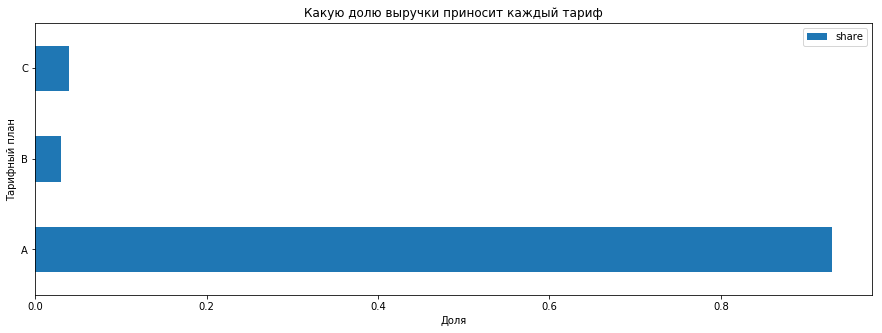

In [328]:
#какой тариф какую долю приносит от общей выручке оператора
temp['share'] = round(temp['cost_all_total']/temp['cost_all_total'].sum(),2)
ax = temp[['share']].plot(kind='barh', figsize=(15,5))
ax.set(title='Какую долю выручки приносит каждый тариф', xlabel='Доля', ylabel='Тарифный план')
plt.show()

In [329]:
temp

,cost_all_total,share
tariff_plan,,
A,"2,848,975,160.69",0.93
B,"79,546,230.39",0.03
C,"133,417,487.60",0.04


## Вывод:
* Наибольшую долю выручки генерирует самый дорогой тарифный план - A
* Доля выручки по тарифному плану A - 93%
* Доля выручки по тарифному плану B - 3%
* Доля выручки по тарифному плану C - 4%

#### 6.2 Построим распределения выручки оператора на каждом тарифном плане
* По клиентам за каждый месяц

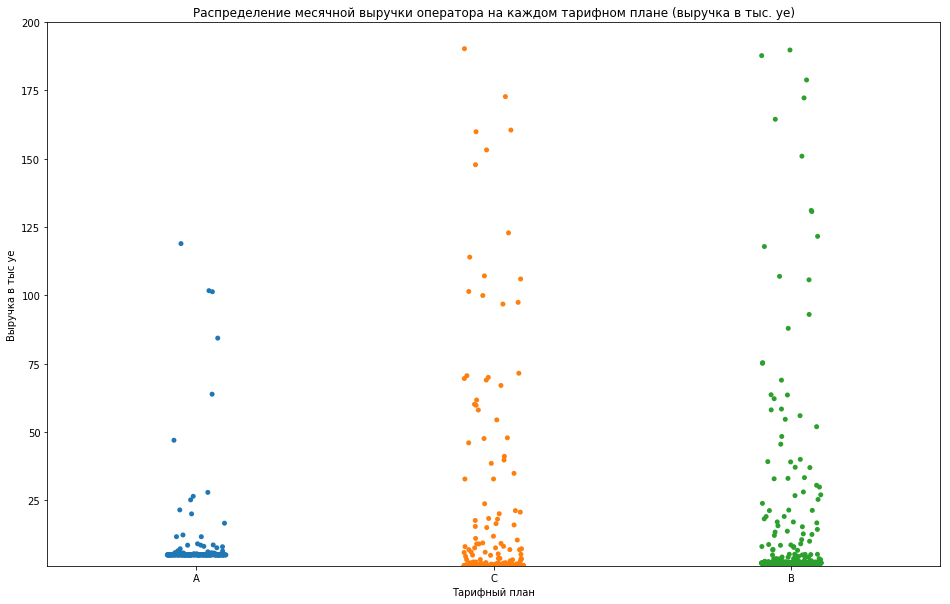

In [330]:
temp = df.copy()
temp = df[['tariff_plan','cost_all_total']]
temp['cost_all_total'] = (temp['cost_all_total'])/1000
plt.figure(figsize=(16, 10))
ax = sns.stripplot(x="tariff_plan", y="cost_all_total", data=temp)
ax.set(title = 'Распределение месячной выручки оператора на каждом тарифном плане (выручка в тыс. уе)', 
       ylabel = 'Выручка в тыс уе', xlabel = 'Тарифный план', ylim=(1,200))
plt.show()

## Вывод:

In [332]:
#сгруппируем суммарную выручку с каждого клиента
temp = df.groupby(['user_id','tariff_plan']).agg({'cost_all_total':'sum'}).reset_index()
temp['cost_all_total'] = temp['cost_all_total']/1000
for tariff in temp['tariff_plan'].unique():
    median_cl = temp[temp['tariff_plan']==tariff].cost_all_total.median()
    mean_cl = temp[temp['tariff_plan']==tariff].cost_all_total.mean()
    print('----------')
    print(f'Метрики по выручке оператора в тарифном плане {tariff}')
    print(f'Медианный клиент приносит выручки на = {round(median_cl,2)} тыс уе,'
          f'Средний клиент приносит = {round(mean_cl,2)} тыс уе')
    percentill_list = np.percentile(temp[temp['tariff_plan']==tariff]['cost_all_total'], [95, 99])
    print(f'5%клиентов приносят {round(percentill_list[0],2)} тыс уе выручки,\n'
    f'1% клиентов приносят {round(percentill_list[1],2)} тыс уе выручки')
    print()

----------
Метрики по выручке оператора в тарифном плане C
Медианный клиент приносит выручки на = 3.0 тыс уе,Средний клиент приносит = 337.77 тыс уе
5%клиентов приносят 415.92 тыс уе выручки,
1% клиентов приносят 5822.22 тыс уе выручки

----------
Метрики по выручке оператора в тарифном плане B
Медианный клиент приносит выручки на = 6.14 тыс уе,Средний клиент приносит = 304.77 тыс уе
5%клиентов приносят 604.28 тыс уе выручки,
1% клиентов приносят 4244.71 тыс уе выручки

----------
Метрики по выручке оператора в тарифном плане A
Медианный клиент приносит выручки на = 20.0 тыс уе,Средний клиент приносит = 37486.52 тыс уе
5%клиентов приносят 28155.28 тыс уе выручки,
1% клиентов приносят 931213.67 тыс уе выручки



---

### 6. Определим оптимальные тарифы для каждого пользователя за каждый месяц

 1. __Понижение класса тарифа рекомендуем__, когда пользователю за __весь период данных__ выгодно пользоваться тарифом более низкого класса, чем текущий.
 2. __Повышение класса тарифа рекомендуем__, если пользователю за __весь период данных__ выгодно пользоваться тарифом более высокого класса
 3. __Тариф без изменений рекомендуем__ пользователю, если сейчас у него оптимальный тариф в плане расходов за весь период и переход на тариф другого класса будет невыгоден.

__Напишем функцию для вычисления оптимального тарифа для каждого клиента за период__

__Используем ранее объявленные словари с параметрами по каждому тарифу(данные в секундах):__
    * parametres_internal_call = {'A':0.1/60, 'B':0.15/60, 'C':0.3/60}
    * parametres_external_call = {'A':0.4/60, 'B':0.5/60, 'C':0.7/60}
    * parametres_tariff = {'A':5000, 'B':2000, 'C':1000}
    * limit_internal_call = 2000*60

In [333]:
parametres_internal_call = {'A':0.1/60, 'B':0.15/60, 'C':0.3/60}
parametres_external_call = {'A':0.4/60, 'B':0.5/60, 'C':0.7/60}
parametres_tariff = {'A':5000, 'B':2000, 'C':1000}
limit_internal_call = 2000*60

In [334]:
def get_best_tariff(df=df):
    '''
    Определяет самый выгодный тариф для юзера учитывая расходы юзера за каждый месяц
    '''
    user_list = []
    best_tariff_list = []
    #создаем временные датафреймы по каждому юзеру
    for user in df.user_id.unique():
        #создаем словарь со списками стоимость в который будем записывать суммарные результаты по каждому юзеру
        total_by_user = {i:[] for i in parametres_internal_call.keys()}
        #создаем временный датафрейм по одному юзеру
        temp = df[df['user_id']==user]
        
        def in_one_user_df(x):
            '''
            Ф-я для apply. Считает расходы по каждому тарифу для одного юзера за один месяц, отправляет данные в total_by_user
            Ничего не возвращает в датафрейм.
            '''
            #словарь в который пишем результаты по каждой строке временного датафрейма по каждому тарифу
            cost_by_tariff = {}
            for i in parametres_internal_call.keys():
                external = parametres_external_call[i]*x.external_total_seconds
                if x.internal_after_limit_sec > 0:
                    internal = parametres_internal_call[i]*x.internal_after_limit_sec
                else:
                    internal = 0
                total = external + internal + parametres_tariff[i]
                cost_by_tariff[i] = round(total,2)
                #после выхода из одной строки в рамках датафрейма по одному юзеру аппендим результат в список по тарифу
            for key, value in cost_by_tariff.items():
                total_by_user[key].append(value)
                
        temp['no_column_no_doubt'] = temp.apply(in_one_user_df, axis=1)
        #записываем сумму списка в значении по каждому тарифу словаря в рамках одного юзера
        total_by_user = {key:sum(value) for key, value in total_by_user.items()}
        #определяем самый дешевый тариф для юзера
        best_tariff = [key for key, value in total_by_user.items() if value == min(total_by_user.values())][0]
        #записываем в список юзера и его лучший тариф
        user_list.append(user)
        best_tariff_list.append(best_tariff)
    #после выхода из цикла по юзерам создаем финальный датафрейм по каждому юзеру с лучшим тарифом
    df_best_tariff = pd.DataFrame({'user_id':user_list, 'best_tariff':best_tariff_list})
    return df_best_tariff

In [335]:
df_best_tariff = get_optimal_tariff()

In [336]:
#проверка
df_clients.shape[0] == df_best_tariff.shape[0]

True

In [337]:
df_best_tariff.tail()

,user_id,best_tariff
727,167813,C
728,168340,C
729,167981,C
730,168025,A
731,168356,C


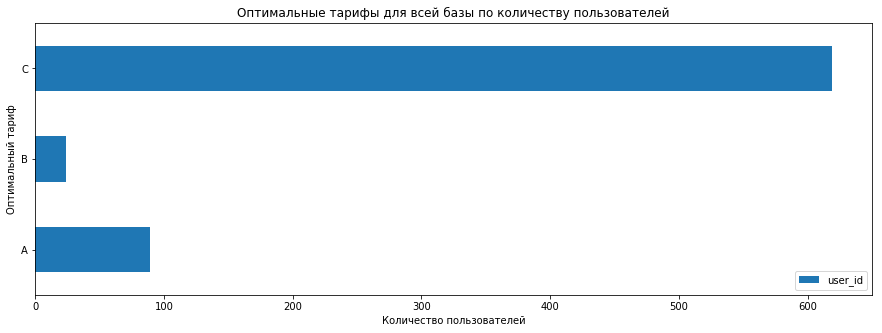

In [340]:
ax = df_best_tariff.groupby('best_tariff').agg({'user_id':'nunique'}).plot(kind='barh', figsize=(15,5))
ax.set(title='Оптимальные тарифы для всей базы по количеству пользователей', ylabel='Оптимальный тариф', 
       xlabel='Количество пользователей')
plt.show()

#### 6.1 Примержим оптимальные тарифы к основному датафрейму

In [341]:
df = df.merge(df_best_tariff, on='user_id', how='left')

In [342]:
df.head()

,month,user_id,tariff_plan,date_start,month_start,internal_calls_count,internal_call_duration,internal_total_call_duration,external_calls_count,external_call_duration,external_total_call_duration,operator_nunique,cost_tariff_monthly,cost_nunique_operators,internal_total_seconds,internal_after_limit_sec,cost_internal_call,external_total_seconds,cost_external_call,cost_all_total,best_tariff
0,2019-08-01,166713,A,2019-08-15,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00",C
1,2019-08-01,166901,A,2019-08-23,2019-08-01,21,1201,1445,13,387,418,4,5000,400,25221,-94779,0.00,5031,33.54,"5,433.54",C
2,2019-08-01,167050,A,2019-08-29,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00",C
3,2019-08-01,166610,A,2019-08-12,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00",C
4,2019-08-01,166897,A,2019-08-23,2019-08-01,0,0,0,0,0,0,0,5000,0,0,-120000,0.00,0,0.00,"5,000.00",C


In [ ]:
#старая функция для истории
#-----------------------
# def get_best_tariff(x):
#     '''
#     Определяем оптимальный тариф для пользователя в каждом месяце в соответствии с расходами
#     '''
#     #словарик для сохранения расходов при каждом варианте тарифа
#     cost_by_tariff = {}
#     #идем по каждому тарифу
#     for i in parametres_internal_call.keys():
#         #внешние звонки цена в сек*всего секунд в месяц
#         external = parametres_external_call[i]*x.external_total_seconds
#         #если перерасход больше 0, умножаем перетрату в сек на стоимость в сек
#         if x.internal_after_limit_sec > 0:
#             internal = parametres_internal_call[i]*x.internal_after_limit_sec
#         else:
#             internal = 0
#         #суммируем стоимость внешних звонков, стоимость перетраты по внутренним звонкам и стоимость тарифа   
#         total = external + internal + parametres_tariff[i]
#         #округляем и записываем в словарик с ключем - обозначение тарифа
#         cost_by_tariff[i] = round(total,2)
#     #определяем минимальное значение в словаре
#     min_value = min(cost_by_tariff.values())
#     #ищем ключ, обозначение тарифа, по минимальному значению
#     best_tariff = [key for key, value in cost_by_tariff.items() if value == min_value][0]
#     return best_tariff

# #применим функцию
# df['best_tariff'] = df.apply(get_best_tariff, axis=1)

#### 6.1 Напишем функцию для получения рекомендации по смене тарифа, по простым эвристикам:
1. __Текущий тариф__ == __рекомендуемому во всех месяцх__ -> все ок, смена тарифа не нужна
2. __Текущий тариф > рекомендуемому тарифа во всех месяцах__ -> понизить до рекомендуемого
3. __Текущий тариф < рекомендуемого тарифа__ -> повысить до рекомендуемого

In [343]:
#создадим датафрейм с текущим тарифом и рекомендуемыми тарифами по каждому пользователю за все периоды
df_recommendation = df.groupby(['user_id','tariff_plan']).agg({'best_tariff':'unique'}).reset_index()

In [344]:
def get_recommendation(x):
    '''
    Сравниваем текущий тариф пользователя и лучший, дает рекомендацию
    '''
    #словарь для ранжирования тарифов
    dict_params = {'A':3,'B':2, 'C':1}
    #обатный словарь, чтобы вернуть название тарифа по ключу
    dict_params_down = dict(reversed(item) for item in dict_params.items())
    #берем числовое значение текущего тариф из датафрейма
    current_tariff = dict_params[x.tariff_plan]
    #если текущий текущий тарифа == лучшему тарифу, то выходим из ф-и
    if (list(x.tariff_plan) == x.best_tariff) :
        return 'nothing'
    else:
        best_tariff = dict_params[str(x.best_tariff[0])]
        #если текущий тариф больше оптимального -> понижаем тариф до тарифа_X
        if current_tariff > best_tariff:
            return 'decrease_'+ dict_params_down[best_tariff]
        else:
            return 'increase_'+ dict_params_down[best_tariff]

In [345]:
#получаем рекомендацию
df_recommendation['recommedation'] = df_recommendation.apply(get_recommendation, axis=1)

In [346]:
df_recommendation.tail()

,user_id,tariff_plan,best_tariff,recommedation
727,168583,B,[C],decrease_C
728,168598,C,[C],nothing
729,168601,C,[A],increase_A
730,168603,B,[C],decrease_C
731,168606,C,[C],nothing


In [347]:
#дропаем ненужное
df_recommendation.drop(['best_tariff'], axis=1, inplace=True)

# Шаг 4. Визуализация и бизнес метрики
<a class="anchor" id="step_4"></a>

### 7. Найдем, сколько пользователей имеет сейчас оптимальный тариф, а сколько нуждаются в переводе

In [348]:
#проставим соответствие условию
df_recommendation['is_tariff_optimal'] = np.where(df_recommendation['recommedation']=='nothing',
                                                  'optimal','not_optimal')
temp = df_recommendation.groupby('is_tariff_optimal').agg({'user_id':'nunique'})\
                                                     .rename(columns={'user_id':'cnt_users'})\
                                                     .reset_index()
#найдем долю
temp['share'] = temp['cnt_users']/temp['cnt_users'].sum()

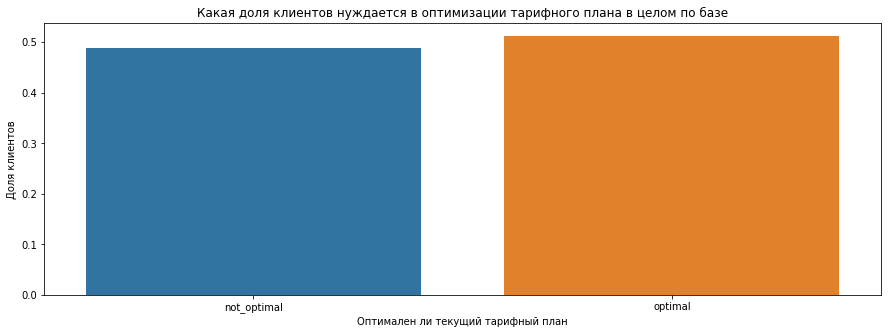

In [349]:
plt.figure(figsize=(15, 5)) 
ax = sns.barplot(x='is_tariff_optimal', y='share', data=temp)
ax.set(title='Какая доля клиентов нуждается в оптимизации тарифного плана в целом по базе', 
       xlabel='Оптимален ли текущий тарифный план', 
       ylabel='Доля клиентов')
plt.show()

In [350]:
temp

,is_tariff_optimal,cnt_users,share
0,not_optimal,357,0.49
1,optimal,375,0.51


## Вывод:
* Текущий тарифный план оптимален для 51% клиентов (375 компании)
* В оптимизации текущего плана нуждаются 49% клиентов (357 компании)

### 7.1 Посмотрим, сколько пользователей приходится на каждую рекомендацию

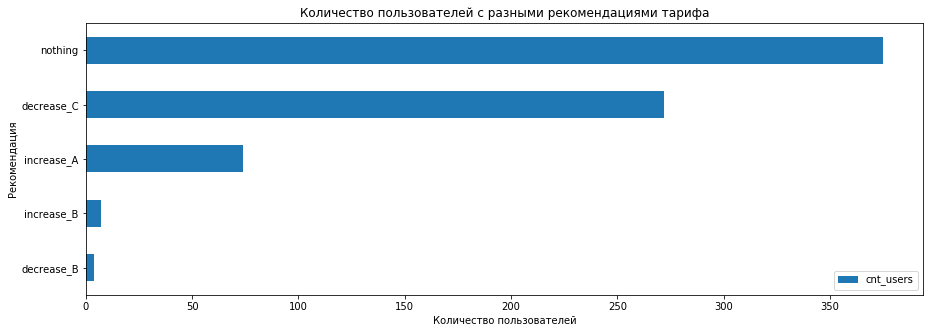

In [351]:
#абсолютные цифры
temp = df_recommendation.groupby('recommedation').agg({'user_id':'nunique'})\
                                                .rename(columns={'user_id':'cnt_users'})\
                                                .sort_values('cnt_users')
ax = temp.plot(kind='barh', figsize=(15,5))
ax.set(title='Количество пользователей с разными рекомендациями тарифа', xlabel='Количество пользователей', ylabel='Рекомендация')
plt.show()

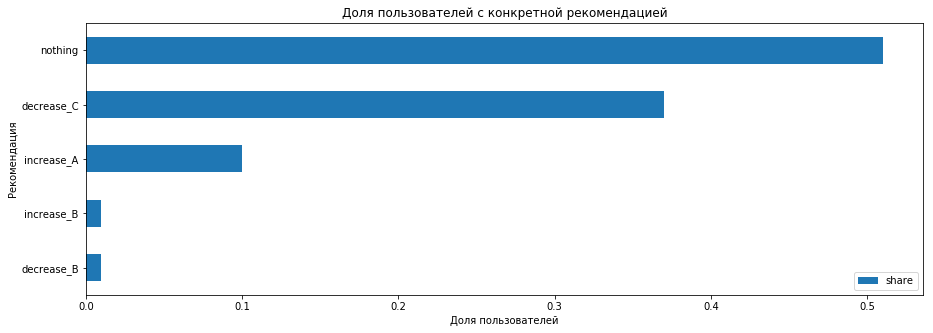

In [352]:
#относительные цифры
temp['share'] = round(temp['cnt_users']/df_recommendation['user_id'].nunique(),2)
ax = temp[['share']].plot(kind='barh', figsize=(15,5))
ax.set(title='Доля пользователей с конкретной рекомендацией', xlabel='Доля пользователей', ylabel='Рекомендация')
plt.show()

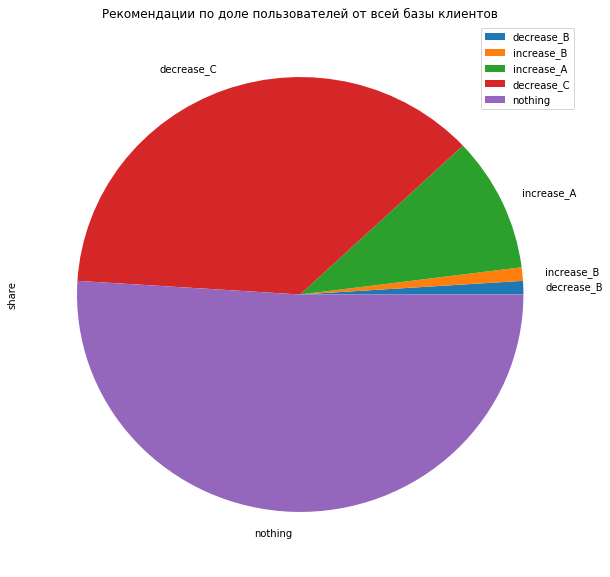

In [353]:
#красивый, но не информативный график для презентации
temp[['share']].plot(kind='pie', subplots=True, figsize=(10, 10))
plt.title("Рекомендации по доле пользователей от всей базы клиентов")
plt.show()

In [354]:
temp

,cnt_users,share
recommedation,,
decrease_B,4,0.01
increase_B,7,0.01
increase_A,74,0.10
decrease_C,272,0.37
nothing,375,0.51


## Вывод:
    * В повышении до тарифа B нуждаются 7 пользователей или 1%
    * В повышении до тарифа A нуждаются 74 пользователя или 10%
    * В понижении до тарифа B нуждаются 4 пользователей или 1% 
    * В понижении до тарифа С нуждаются 272 пользователя или 37%
    * Оптимальные тарифы имеют 375 пользователей или 51%

### 8. В каких оптимизационных действиях нуждаются пользователи на разных тарифах (текущих)

In [355]:
#разделим рекомендацию на две части - действие и оптимальный тариф
df_recommendation[['action', 'optimal_tariff']] = df_recommendation['recommedation'].str.split('_', expand=True)

In [356]:
#там где нет оптимального тарифа, текущий тариф оптимален
df_recommendation.loc[df_recommendation['action']=='nothing','optimal_tariff'] = df_recommendation['tariff_plan']

In [357]:
df_recommendation.tail()

,user_id,tariff_plan,recommedation,is_tariff_optimal,action,optimal_tariff
727,168583,B,decrease_C,not_optimal,decrease,C
728,168598,C,nothing,optimal,nothing,C
729,168601,C,increase_A,not_optimal,increase,A
730,168603,B,decrease_C,not_optimal,decrease,C
731,168606,C,nothing,optimal,nothing,C


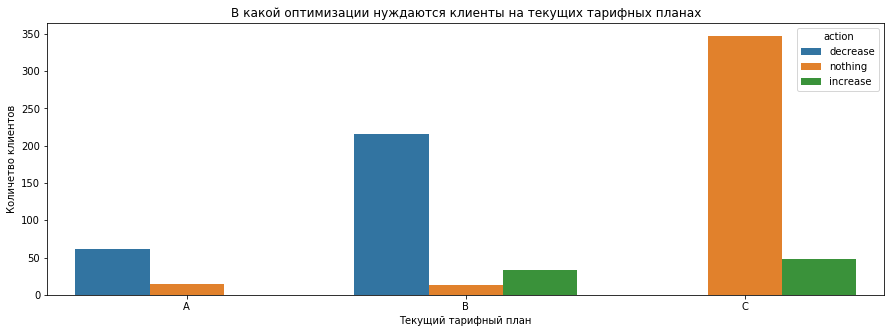

In [358]:
#абсолютные цифры
temp = df_recommendation.groupby(['tariff_plan','action']).agg({'user_id':'nunique'})\
                                                          .rename(columns={'user_id':'cnt_users'})\
                                                          .reset_index()
plt.figure(figsize=(15, 5)) 
ax = sns.barplot(x='tariff_plan', y='cnt_users', hue='action', data=temp)
ax.set(title='В какой оптимизации нуждаются клиенты на текущих тарифных планах', xlabel='Текущий тарифный план', 
       ylabel='Количетво клиентов')
plt.show()

In [359]:
temp

,tariff_plan,action,cnt_users
0,A,decrease,61
1,A,nothing,15
2,B,decrease,215
3,B,increase,33
4,B,nothing,13
5,C,increase,48
6,C,nothing,347


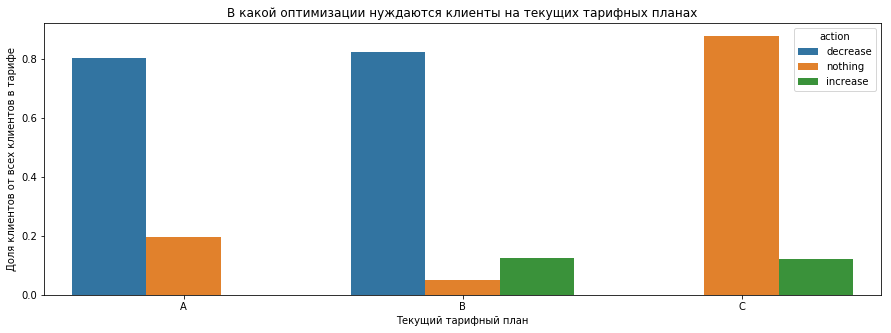

In [360]:
#относительные цифры
temp = ((df_recommendation.groupby(['tariff_plan','action']).agg({'user_id':'nunique'})/
                                df_recommendation.groupby('tariff_plan').agg({'user_id':'nunique'}))).reset_index()
plt.figure(figsize=(15, 5)) 
ax = sns.barplot(x='tariff_plan', y='user_id', hue='action', data=temp)
ax.set(title='В какой оптимизации нуждаются клиенты на текущих тарифных планах', xlabel='Текущий тарифный план', 
       ylabel='Доля клиентов от всех клиентов в тарифе')
plt.show()

In [361]:
temp

,tariff_plan,action,user_id
0,A,decrease,0.80
1,A,nothing,0.20
2,B,decrease,0.82
3,B,increase,0.13
4,B,nothing,0.05
5,C,increase,0.12
6,C,nothing,0.88


## Вывод: 

* > __Текущий тарифный план A__
    * Понижение тарифа будет оптимально 80% пользователей или 61 клиентам
    * План оптимален для 20% или 15 клиентов
* > __Текущий тарифный план B__
    * Понижение тарифа будет оптимально 82% или 215 клиентам
    * Повышение тарифа будет оптимально 13% или 33 клиентам
    * Тариф оптимален для 5% или 13
* > __Текущий тарифный план C__
    * Понижать нет возможности, тк это последний тарифный план в нашей сетке тарифов
    * Повышение тарифного плана будет оптимально для 12% пользователей или 48 клиентам
    * Тариф оптимален для 88% исходя из нашей тарифной сетки или 347 клиенту
    
* Процент пользователей рассчитывался внутри каждого тарифного плана
    

### 9. Как распределяются клиенты по действим оптимизации, посчитаем долю от всей базы клиентов

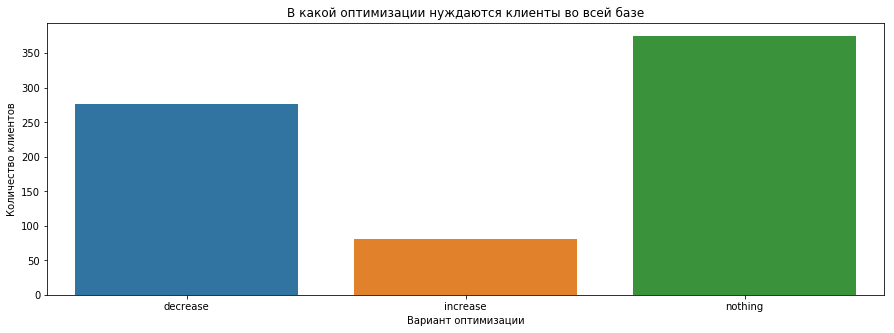

In [362]:
#абсолютные цифры
temp = df_recommendation.groupby('action').agg({'user_id':'nunique'})\
                                             .rename(columns={'user_id':'cnt_users'}).reset_index()
plt.figure(figsize=(15, 5)) 
ax = sns.barplot(x='action', y='cnt_users', data=temp)
ax.set(title='В какой оптимизации нуждаются клиенты во всей базе', xlabel='Вариант оптимизации', 
       ylabel='Количество клиентов')
plt.show()

In [363]:
temp

,action,cnt_users
0,decrease,276
1,increase,81
2,nothing,375


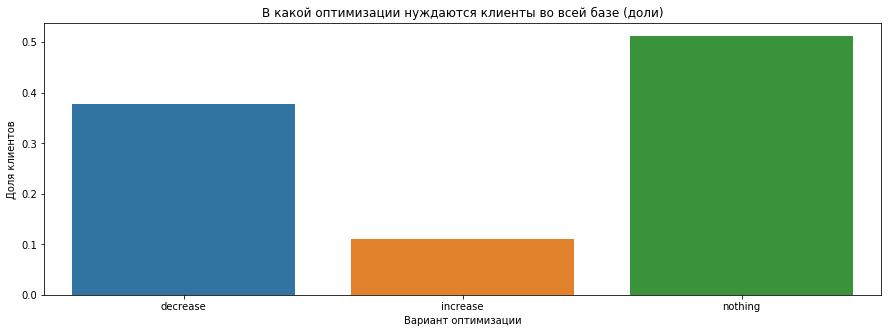

In [364]:
#относительные цифры
temp['share'] = temp['cnt_users']/(temp['cnt_users'].sum())
plt.figure(figsize=(15, 5)) 
ax = sns.barplot(x='action', y='share', data=temp)
ax.set(title='В какой оптимизации нуждаются клиенты во всей базе (доли)', xlabel='Вариант оптимизации', 
       ylabel='Доля клиентов')
plt.show()

In [163]:
temp

,action,cnt_users,share
0,decrease,276,0.38
1,increase,81,0.11
2,nothing,375,0.51


## Вывод:
* __Понижение тарифа оптимально__ для 38% клиентов, 276 компаний
* __Повышение тарифа оптимально__ для 11% клиентов, 81 компаний
* __Текущий тариф оптимален__ для 51% клиентов, 375 компаний

### 10. Сколько выручки потеряет оператор, если переведет всех клиентов на оптимальные тарифы
* Пересчитаем расходы всех клиентов по оптимальным тарифам

In [365]:
df.drop(['best_tariff'], axis=1, inplace=True)

#добавим информацию об оптимальных тарифах и действиях в датафрейм df со всей информацией 
df = df.merge(df_recommendation[['user_id','is_tariff_optimal','action','optimal_tariff']],
        on='user_id', how='left')

#добавим в датафрейм месячную плату за оптимальный тариф
df['cost_tariff_monthly_optimal'] = df['optimal_tariff'].map(parametres_tariff)

__Используем ранее объявленные словари с параметрами по каждому тарифу(данные в секундах):__
    * parametres_internal_call = {'A':0.1/60, 'B':0.15/60, 'C':0.3/60}
    * parametres_external_call = {'A':0.4/60, 'B':0.5/60, 'C':0.7/60}
    * parametres_tariff = {'A':5000, 'B':2000, 'C':1000}
    * limit_internal_call = 2000*60

In [366]:
#стоимость за внутренние звонки по оптимальному тарифу
df['cost_internal_call_optimal'] = df.apply(lambda x: 
                                    round(parametres_internal_call[x.optimal_tariff]*x.internal_after_limit_sec,2)
                                                    if x.internal_after_limit_sec > 0
                                                    else 0, axis=1)
#стоимость за внешние звонки по оптимальному тарифу
df['cost_external_call_optimal'] = df.apply(
                        lambda x: round(parametres_external_call[x.optimal_tariff]*x.external_total_seconds,2), 
                                                                                                            axis=1)

#суммарная стоимость услуг по каждому клиенту за период
df['cost_all_total_optimal'] = (df['cost_nunique_operators'] + 
                                df['cost_tariff_monthly_optimal'] + 
                                df['cost_internal_call_optimal'] + df['cost_external_call_optimal'])

In [367]:
before = df['cost_all_total'].sum()
after = df['cost_all_total_optimal'].sum()
print(f'Выручка оператора за весь период при текущих тарифах {round(before,2)} ye\n'
      f'После перевод на оптимальные тарифы {round(after,2)} ye\n'
      f'Относительное различие {(before-after)/before*100}%')

Выручка оператора за весь период при текущих тарифах 3061938878.68 ye
После перевод на оптимальные тарифы 2989365142.07 ye
Относительное различие 2.3701889386272184%


## Вывод:
* После перевода пользователей на оптимальные тарифы, __оператор потеряет 2,37% выручки__ или __72 573 736,61 уе__
* Выручка оператора за весь период __при текущих тарифах 3 061 938 878.68 ye__
* После перевод на оптимальные тарифы __выручка уменьшится до 2 989 365 142.07 ye__

### 11. LTV

#### 11.1 Посчитаем LTV пользователей с текущими оптимальными тарифами и текущими неоптимальными тарифами

In [368]:
def ltv_func(df, revenue_column):
    '''
    Cчитает LTV для датафрейма df, возвращает pivot_table
    '''
    cohorts = df.groupby(['month_start','month']).agg({revenue_column:'sum'})\
                                             .rename(columns={revenue_column:'revenue'})\
                                             .reset_index()
    #количество клиентов в каждой когорте
    cohort_sizes = df.groupby('month_start').agg({'user_id': 'nunique'})\
                                        .rename(columns={'user_id':'n_buyers'})\
                                        .reset_index()
    #объединим в общую таблицу по месяцу подключения
    report = cohorts.merge(cohort_sizes, on='month_start')
    #найдем внутри когорты возраст для каждой когорты и округлим до месяца
    report['age'] = (report['month'] - report['month_start'])/ np.timedelta64(1,'M')
    report['age'] = report['age'].round().astype('int')
    #выручка в пересчете на одного клиента в когорте
    report['ltv'] = report['revenue']/report['n_buyers']
    #display(report.head())
    ltv = report.pivot_table(index='month_start', columns='age', values='ltv', aggfunc='mean')
    #приджойним размер когорт, чтобы было нагляднее
    ltv = ltv.join(cohort_sizes.set_index('month_start'))
    return ltv

#### 11.2  LTV для всех клиентов

In [474]:
ltv_func(df,'cost_all_total').fillna('')

,0,1,2,3,n_buyers
month_start,,,,,
2019-08-01,"466,167.63","3,411,821.82","2,885,772.72","116,100.99",258
2019-09-01,"330,243.17","1,614,058.10","43,244.98",,231
2019-10-01,"391,925.81","3,014,703.82",,,243


#### 11.3  LTV для клиентов с оптимальными тарифами

In [473]:
ltv_func(df[df['is_tariff_optimal']=='optimal'], 'cost_all_total').fillna('')

,0,1,2,3,n_buyers
month_start,,,,,
2019-08-01,"862,853.92","6,464,693.11","5,397,043.40","7,478.24",132
2019-09-01,"443,276.41","2,720,172.21","6,646.62",,130
2019-10-01,"507,352.27","6,190,088.32",,,113


#### 11.4 LTV для клиентов с неоптимальными тарифами

In [472]:
ltv_func(df[df['is_tariff_optimal']=='not_optimal'], 'cost_all_total').fillna('')

,0,1,2,3,n_buyers
month_start,,,,,
2019-08-01,"50,591.52","213,575.71","254,917.72","229,896.24",126
2019-09-01,"184,754.85","190,346.88","90,351.78",,101
2019-10-01,"291,593.57","254,561.90",,,130


#### 11.5 Посчитаем метрики для выручки по тарифом с оптимальным и не оптимальным тарифом

In [478]:
df.groupby('is_tariff_optimal').agg({'cost_all_total':['mean','median','std'], 'user_id':'nunique'})

cost_all_total                        user_id
                            mean   median           std nunique
is_tariff_optimal                                              
not_optimal           199,046.53 2,000.00  1,395,610.98     357
optimal             2,490,870.83 1,000.00 39,236,085.91     375

## Вывод:
* Клиенты с оптимальным тарифом имеет больший LTV, но возможно результат искажают "киты" в группе оптимальных с тарифом A и большим расходом.

### 12. Retention Rate
* RR = (Количество активных пользователей на n-й lifetime / Количество активных пользователей на 0 lifetime)*100%
* В качестве активности будем считать звонки, (кроме оплаты абонентской платы) и подключение

In [439]:
#проставим активность для пользователей по месяцам
df['activity'] = df.apply(lambda x: 
            1 if (x.month == x.month_start) or ((x.internal_total_seconds+x.external_total_seconds)>0)
                          else 0, axis=1)

In [461]:
def retention_rate(df):
    '''
    Считает Retention Rate, возвращает сводную
    '''
    cohorts = df[df['activity']!=0].groupby(['month_start','month']).agg({'user_id':'nunique'})\
                                         .rename(columns={'user_id':'n_byuers'})\
                                         .reset_index()
    cohorts['age'] = (cohorts['month'] - cohorts['month_start'])/ np.timedelta64(1,'M')
    cohorts['age'] = cohorts['age'].round().astype('int')
    size = cohorts[cohorts['age']==0][['month_start','n_byuers']].rename(columns={'n_byuers':'cohort_users'})
    cohorts = cohorts.merge(size, on='month_start', how='left')
    cohorts['retention'] = cohorts['n_byuers']/cohorts['cohort_users']
    return cohorts.pivot_table(index='month_start', columns='age', values='retention', aggfunc='mean')

#### 12.1 RR для клиентов с оптимальными тарифами

In [464]:
retention_rate(df[df['is_tariff_optimal']=='optimal']).fillna('')

age,0,1,2,3
month_start,,,,
2019-08-01,1.00,0.16,0.14,0.12
2019-09-01,1.00,0.14,0.13,
2019-10-01,1.00,0.21,,


#### 12.2 RR для клиентов с неоптимальными тарифами

In [465]:
retention_rate(df[df['is_tariff_optimal']=='not_optimal']).fillna('')

age,0,1,2,3
month_start,,,,
2019-08-01,1.00,0.38,0.32,0.33
2019-09-01,1.00,0.34,0.35,
2019-10-01,1.00,0.27,,


* Как бы это не было странно, у неоптимальных тарифов выше ретеншн (в активность). 
* Это объясняет большую долю пассивных клиентов на тарифе C, оптимальным для клиентов с нулевым расходом и находящимся на самом последнем месте в тарифной сетке

#### 12.3 Уберем тариф C - убежище для спящих клиентов. Сравним RR для оптимальных тарифов и неоптимальных.

#### RR, текущий тариф неоптимален

In [470]:
retention_rate(df[(df['is_tariff_optimal']=='not_optimal') & (~df['tariff_plan'].isin(['C']))]).fillna('')

age,0,1,2,3
month_start,,,,
2019-08-01,1.00,0.29,0.24,0.24
2019-09-01,1.00,0.20,0.22,
2019-10-01,1.00,0.21,,


#### RR, текущий тариф оптимален

In [471]:
retention_rate(df[(df['is_tariff_optimal']=='optimal') & (~df['tariff_plan'].isin(['C']))]).fillna('')

age,0,1,2,3
month_start,,,,
2019-08-01,1.00,0.88,1.00,0.88
2019-09-01,1.00,0.90,0.60,
2019-10-01,1.00,1.00,,


### Совершенно другое дело. RR больше у клиентов с оптимальными тарифами.

## Вывод:
* Как бы это не было странно, у неоптимальных тарифов выше ретеншн (в активность). 
* Но это объяснимо большой долей пассивных клиентов на тарифе C, оптимальным для клиентов с нулевым расходом и находящимся на самом последнем месте в тарифной сетке
* __Если сравнивать RR по оптимальным тарифам, исключая текущий тариф C, то RR в 2,5 раза выше у клиентов с оптимальным тарифом__

----

# Шаг 5. Кластеризация
<a class="anchor" id="step_5"></a>

### 13. ML. Применим кластеризацию Kmeans
* Посмотрим, как разделятся наши клиенты на разные кластеры

#### 13.1 Отфильтруем датафрейм, уберем
   1. Фичи с мультиколлинеарностью, в частности все %optimal значения, тк они скоррелированы с изначальными данными
   2. Даты - тк не имеет смысла их использовать в модели
   3. user_id, тк это уникальная характеристика, не имеет никакого объединяющего свойства с другими объектами

In [374]:
#выведем топ корреляций по модулю, исключив корреляции == 1 по диагонали
df_cor=(df.corr(method='spearman')).abs().unstack().sort_values(ascending=False).reset_index()
df_cor.columns = ['Feature_1', 'Feature_2','r']
df_cor.query('r!=1')

,Feature_1,Feature_2,r
24,cost_internal_call,cost_internal_call_optimal,1.00
25,cost_internal_call_optimal,cost_internal_call,1.00
26,internal_call_duration,internal_total_call_duration,1.00
27,internal_total_call_duration,internal_call_duration,1.00
28,cost_external_call_optimal,external_total_seconds,1.00
29,external_total_seconds,cost_external_call_optimal,1.00
30,internal_after_limit_sec,internal_total_call_duration,1.00
31,internal_total_call_duration,internal_after_limit_sec,1.00
32,internal_total_call_duration,internal_total_seconds,1.00
33,internal_total_seconds,internal_total_call_duration,1.00


In [375]:
bad_feature_list = ['month','operator_nunique',
                    'date_start','month_start','action','internal_after_limit_sec','tariff_plan']
df_clus = df[[i for i in df if ('optimal' not in i) and 
              #('cost' not in i) and 
              (i not in bad_feature_list) and
              ('total' not in i) and
              ('count' not in i)
             ]]

#cоберем по каждому юзеру агрегаты, тк в исходном датафрейме были периоды
df_clus = df_clus.groupby('user_id').agg({i:'sum' for i in df_clus if i != 'user_id'})\
                                    .reset_index()
#дропнем юзер айди и пересохраним
df_clus_new = df_clus.drop(['user_id'], axis=1)

#### 13.2 Стандартизируем числовые значения

In [376]:
df_clus_list = df_clus_new.columns
#стандартизируем
df_clus_new = StandardScaler().fit_transform(df_clus_new)
#восстановим датафрейм
df_clus_new = pd.DataFrame(df_clus_new, columns=df_clus_list).astype('float64')

In [377]:
df_clus_new.head()

,internal_call_duration,external_call_duration,cost_tariff_monthly,cost_nunique_operators,cost_internal_call,cost_external_call
0,-0.12,-0.12,-0.33,-0.33,-0.10,-0.06
1,-0.12,-0.12,-0.33,-0.33,-0.10,-0.06
2,-0.12,-0.12,-0.33,-0.33,-0.10,-0.06
3,-0.12,-0.12,-0.33,-0.33,-0.10,-0.06
4,-0.10,0.71,0.70,2.27,-0.10,-0.03


#### 13.3 Построим дендрограмму

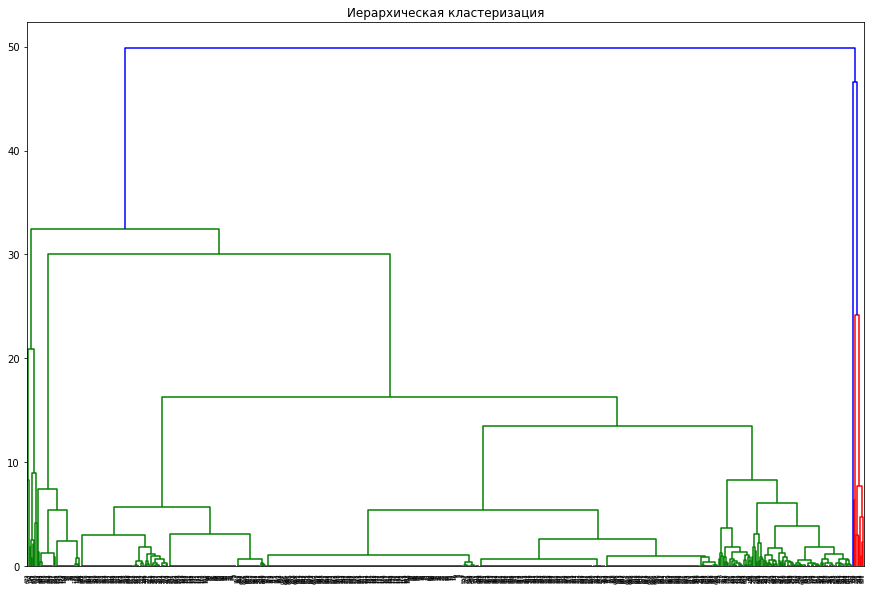

In [378]:
#сгенерируем матрицу
linked = linkage(df_clus_new, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

> __Можно выделить 3 кластера__

In [416]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3)
#прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
#сохраняем в переменную labels
labels = km.fit_predict(df_clus_new)
# сохраняем метки кластера в поле изначального датасета
df_clus['cluster'] = labels

In [417]:
df_clus.head()

,user_id,internal_call_duration,external_call_duration,cost_tariff_monthly,cost_nunique_operators,cost_internal_call,cost_external_call,cluster
0,166373,0,0,4000,0,0.00,0.00,0
1,166374,0,0,4000,0,0.00,0.00,0
2,166375,0,0,4000,0,0.00,0.00,0
3,166376,0,0,4000,0,0.00,0.00,0
4,166377,132,310419,8000,1800,0.00,"2,078,960.20",0


>   **_<span style="color:red">Давай для каждого из кластеров выведем гистограммы распределений признаков, разных цветов для разного кластера (`sns.distplot()`) – как делали многие студенты в прошлом спринте, возможно, ты тоже.</span>_**

### -- Ок, поправил

#### 13.4 Посчитаем основные статистики, чтобы понять по какому принципу сформировались кластеры

In [421]:
df_clus.groupby('cluster').agg({i:['median','mean','std'] for i in df_clus if i not in ['user_id','cluster']})

internal_call_duration                     external_call_duration  \
                        median      mean       std                 median   
cluster                                                                     
0                            0    145.45  1,044.71                      0   
1                            0      5.67      9.81                4240557   
2                        36400 47,456.89 24,027.43                 159617   

                                  cost_tariff_monthly                     \
                mean          std              median      mean      std   
cluster                                                                    
0          20,341.55   103,994.22                4000  5,211.11 3,780.10   
1       5,182,145.33 2,829,257.49               15000 15,000.00 5,000.00   
2         208,752.56   169,398.91                6000  8,333.33 5,809.48   

        cost_nunique_operators                   cost_internal_call            \
                        median     mean      std             median      mean   
cluster                                                                         
0                            0   178.75   515.28               0.00      8.41   
1                         4800 4,900.00 4,150.90               0.00      0.00   
2                         2200 2,588.89   961.05          34,491.44 43,857.36   

                  cost_external_call                                
              std             median           mean            std  
cluster                                                             
0          136.35               0.00     343,528.88   2,681,465.42  
1            0.00     681,969,600.16 920,396,713.16 671,790,346.64  
2       27,867.66         716,164.83   5,440,941.26  11,079,108.76

## Вывод:
1. Кластер 0: среднее количество внутренних звонков, самое низкое количество внешних звонков, самые небольшие расходы, почти не звонят внешним операторам
2. Кластер 1: самое большое количество внутренних звонков, среднее количество внешних звонков, средние расходы на операторов в месяц
3. Кластер 2: не пользуются внутренней связью, самые большие расходы на внешние звонки, много внешних операторов.
* По сути фичи cost_% являются производными (c поправкой на тариф) и возможно их стоит убрать для того, чтобы снизить размерность

#### 13.5 Посмотрим на содержание тарифов в каждом кластере

In [419]:
temp = (df_clus[['user_id','cluster']]).merge(df_clients[['user_id','tariff_plan']], how='left', on='user_id')
temp.groupby(['cluster','tariff_plan']).agg({'user_id':'count'})

user_id
cluster tariff_plan         
0       A                 70
        B                257
        C                393
1       A                  3
2       A                  3
        B                  4
        C                  2

#### В кластере 0 сосредоточено большинство пользователей. Видимо, кластеры 1 и 2 очень сильно отличаются от кластера 0, о чем нам и говорят статистики.

#### 13.6 Построим распределения непрерывных переменных в разных кластерах

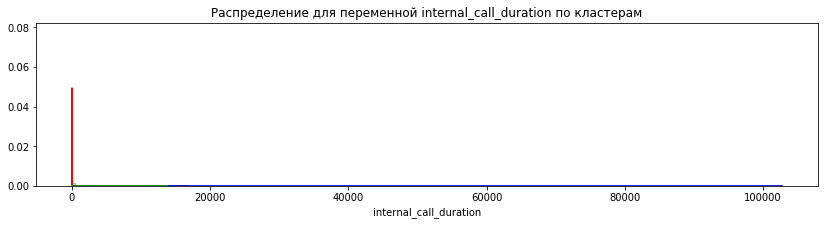

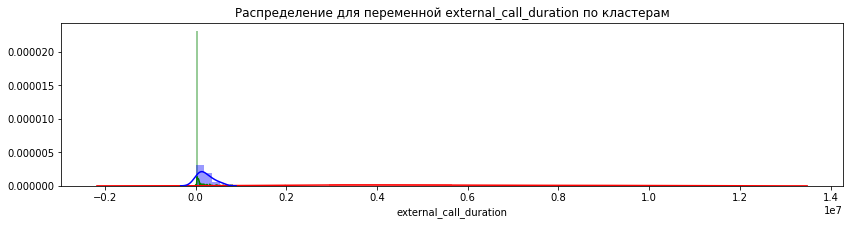

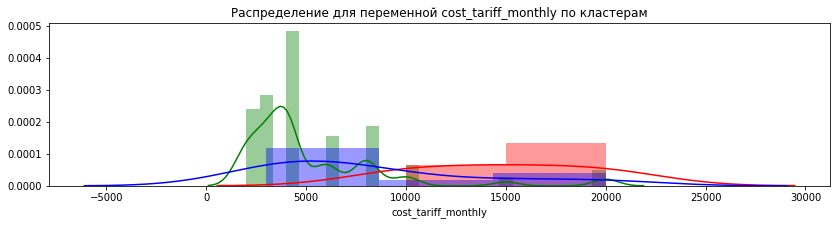

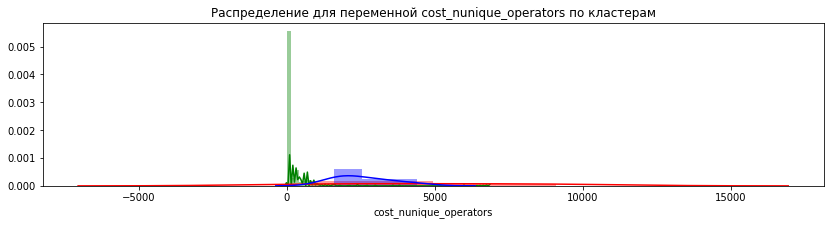

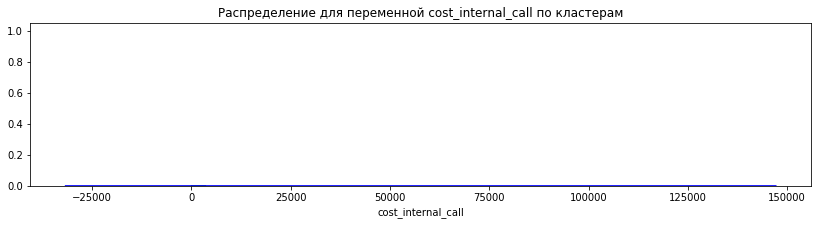

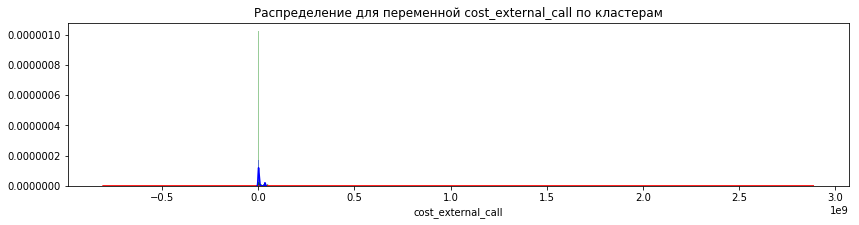

In [420]:
numerical_columns = [i for i in df_clus if (i != 'cluster') and (i != 'user_id')]
for feature in numerical_columns:
    plt.figure(figsize=(14, 3))
    ax = sns.distplot(df_clus[df_clus['cluster']==0][feature], color="green")
    ax.set(title=f'Распределение для переменной {feature} по кластерам')
    ax = sns.distplot(df_clus[df_clus['cluster']==1][feature], color="red")
    ax = sns.distplot(df_clus[df_clus['cluster']==2][feature], color="blue")
    plt.show()

## Вывод
1. Кластер 0: среднее количество внутренних звонков, самое низкое количество внешних звонков, самые небольшие расходы, почти не звонят внешним операторам
2. Кластер 1: самое большое количество внутренних звонков, среднее количество внешних звонков, средние расходы на операторов в месяц
3. Кластер 2: не пользуются внутренней связью, самые большие расходы на внешние звонки, много внешних операторов.
* По сути фичи cost_% являются производными (c поправкой на тариф) и возможно их стоит убрать для того, чтобы снизить размерность
* Судя по веткам на иерархическом графике, можно выделить 7 кластеров(хотя они и не окрашены другим цветом), либо отдельно кластеризовать самый большой 0 кластер. Попробовал, действительно разделяется иным способом. Но интересно, как выбрать оптимальное число кластеров? Почитал, что решается перебором и нахождением минимальных кластерных расстояний. __Есть вопрос: правильно ли я понимаю, что кластерный анализ применяют всегда там, где очень много переменных и сложно выяснить аналитически все взаимосвязи?__

---

# Шаг 6. Формирование выводов
<a class="anchor" id="step_6"></a>

## Вывод
* Задача заключалась в том, чтобы найти клиентов, которые: 
    * а) __переплачивают на текущих тарифах__
        * Клиенты, которые переплачивают - в базе таких: 357 клиентов или 49% от всей базы
    * б) __требуют повышения тарифного плана, т.к. им это будет выгоднее__
        * Клиенты, которым выгодно повышение тарифа - 81 клиентов или 11% от всей базы

---
## > Общая информация о базе и текущие тарифы
---
* В базе (датафрейме df_clients) 732 уникальных пользователей
* 425 уникальных клиентов без активности, но которые платят абонентскую плату
* Тк у нас нет данных о прекращении использования услуг каким либо пользователем, то всех пользователей считаем активными -> платящими за тариф во всех периодах
* В наличии данные с 2019-08-01  по 2019-11-28, есть ограничения по началу контракта
---

### Сколько клиентов на каждом тарифе (текущий тариф)
1. Текущий __тарифный план A__ имеют 75 клиентов или 10%
2. Текущий __тарифный план B__ имеют 261 клиент или 36%
3. Текущий __тарифный план C__ имеют 395 клиент или 54%
---
### Метрики по каждому тарифу (текущий тариф)
__Метрики по выручке оператора в тарифном плане C__
* Медианный клиент приносит выручки на = 3.0 тыс уе
* Средний клиент приносит = 337.77 тыс уе
* 5% клиентов приносят 415.92 тыс уе выручки,
* 1% клиентов приносят 5822.22 тыс уе выручки

----------
__Метрики по выручке оператора в тарифном плане B__
* Медианный клиент приносит выручки на = 6.14 тыс уе
* Средний клиент приносит = 304.77 тыс уе
* 5% клиентов приносят 604.28 тыс уе выручки,
* 1% клиентов приносят 4244.71 тыс уе выручки

----------
__Метрики по выручке оператора в тарифном плане A__
* Медианный клиент приносит выручки на = 20.0 тыс уе
* Средний клиент приносит = 37486.52 тыс уе
* 5% клиентов приносят 28155.28 тыс уе выручки,
* 1% клиентов приносят 931213.67 тыс уе выручки

---
## > Оптимизация текущих тарифов
---
### Ситуация с текущими тарифами
__Процент пользователей рассчитывался внутри каждого тарифного плана__
* Текущий тариф оптимален для 51% клиентов (375 компании)
* В оптимизации текущего плана нуждаются 49% клиентов (357 компании)


### Текущий тарифный план A
* Понижение тарифа будет оптимально 80% пользователей или 61 клиентам
* План оптимален для 20% пользователей или 15 клиентов


### Текущий тарифный план B
* Понижение тарифа будет оптимально 82% или 215 клиентам
* Повышение тарифа будет оптимально 13% или 33 клиентам
* Тариф оптимален для 5% или 13

### Текущий тарифный план C
* Понижать нет возможности, тк это последний тарифный план в нашей сетке тарифов
* Повышение тарифного плана будет оптимально для 12% пользователей или 48 клиентам
* Тариф оптимален для 88% исходя из нашей тарифной сетки или 347 клиенту

---

### Действия по пользователям во всей базе: понижение и повышение тарифов
* __Понижение тарифа оптимально__ для 38% клиентов, 276 компаний
* __Повышение тарифа оптимально__ для 11% клиентов, 81 компаний
* __Текущий тариф оптимален__ для 51% клиентов, 375 компаний

---

## > Выручка оператора до и после оптимизации тарифов
---

### Выручка оператора на текущих тарифах
__Наибольшую долю выручки генерирует самый дорогой тарифный план - A__
* Доля выручки по тарифному плану A - 93%
* Доля выручки по тарифному плану B - 3%
* Доля выручки по тарифному плану C - 4%

---

### Выручка оператора после оптимизации тарифов
* После перевода пользователей на оптимальные тарифы, __оператор потеряет 2,37% выручки__ или __72 573 736,61 уе__
* Выручка оператора за весь период __при текущих тарифах 3 061 938 878.68 ye__
* После перевод на оптимальные тарифы __выручка уменьшится до 2 989 365 142.07 ye__

---

## > LTV
---
* LTV выше для клиентов с оптимальным тарифом. Но на LTV сильно влияют клиенты с большим расходом.

---
## > Retention Rate

* Как бы это не было странно, у неоптимальных тарифов выше ретеншн (в активность). 
* Но это объяснимо большой долей пассивных клиентов на тарифе C, оптимальным для клиентов с нулевым расходом и находящимся на самом последнем месте в тарифной сетке
* __Если сравнивать RR по оптимальным тарифам, исключая текущий тариф C, то RR в 2,5 раза выше у клиентов с оптимальным тарифом__

---

# Дашборд
<a class="anchor" id="step_7"></a>
* Тк не было подробностей какой дашборд нужен, то используем DataStudio - объем данных позволяет нам это сделать.
* Выгрузка датафрейма df происходит в таблицу, доступна по ссылке: [ссылка на таблицу](https://docs.google.com/spreadsheets/d/1a81CXDXi4qhjNDqfi2gim0t26Z02lJCHuXN6NOLwrzk/edit?usp=sharing) 
* Дашборд забирает данные из таблицы и доступен по ссылке: [ссылка на дашборд](https://datastudio.google.com/reporting/6e96f524-ab6c-4d43-852d-df9009ceb2c5)
* Подключение требует получение API ключа, закомментировано, чтобы не давать ошибку

In [388]:
#pip install gspread oauth2client df2gspread
from df2gspread import df2gspread as d2g
import gspread
from oauth2client.service_account import ServiceAccountCredentials
#часть юрл из шитса, ключ
spreadsheet_key = '1a81CXDXi4qhjNDqfi2gim0t26Z02lJCHuXN6NOLwrzk'
#часть юрл
scope = ['https://spreadsheets.google.com/feeds']
#скачиваем json файл с ключом и в настройках api, открываем доступ к google sheets
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    'path_to_json_file', scope)
gc = gspread.authorize(credentials)
#названия рабочего листа в шитсах
wks_name = 'Dashboard'
d2g.upload(df, spreadsheet_key, wks_name, credentials=credentials, row_names=True)

<Worksheet 'Dashboard' id:0>

### Дашборд: https://datastudio.google.com/reporting/6e96f524-ab6c-4d43-852d-df9009ceb2c5

---

# Шаг 7. Презентация

https://docs.google.com/presentation/d/1euhRO9ONJCM3eE9_lqoDF4sGJfR_mUbZBtg9jSZCqao/export/pdf